In [1]:
class CFG:
    seed = 4121995
    undersample_no_contact = True
    img_size = 224
    model = 'resnet18'  
    epochs = 20
    train = False
    valid = False
    infer = True
    thresh = 0.64
    dist_thresh = 2
    model_name = 'rgb-bbox-1'

In [2]:
LS = !ls
IS_KAGGLE = 'init.sh' not in LS
IS_KAGGLE

False

In [3]:
import sys

if IS_KAGGLE:
    sys.path.append('/kaggle/input/timm-0-6-9/pytorch-image-models-master')
    CFG.frames_path = ''
    CFG.utils_path = '/kaggle/input/nflutils'
    
    sys.path.insert(0, '../input/nflutils')
    !mkdir -p nflutils
    !cp ../input/nflutils/*.py nflutils/
    
else:
    CFG.frames_path = 'frames/content/work/frames/train'
    CFG.utils_path = 'nflutils'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import pickle
import timm

from pathlib import Path

from nflutils.dataprep import *

from tqdm.notebook import tqdm

from sklearn.metrics import matthews_corrcoef

In [5]:
if IS_KAGGLE:
    BASE_DIR = Path("../input/nfl-player-contact-detection")
    OUT_DIR = Path("/kaggle/working/")
else:
    BASE_DIR = Path("nfl-player-contact-detection")
    OUT_DIR = Path("nfl-player-contact-detection/frames")

In [6]:
labels = pd.read_csv(f"{BASE_DIR}/train_labels.csv", parse_dates=["datetime"])

tr_tracking = pd.read_csv(
    BASE_DIR/"train_player_tracking.csv", parse_dates=["datetime"]
)


tr_helmets = pd.read_csv(BASE_DIR/"train_baseline_helmets.csv")

tr_video_metadata = pd.read_csv(
    BASE_DIR/"train_video_metadata.csv",
    parse_dates=["start_time", "end_time", "snap_time"],
)

In [7]:
from torch.utils.data import Dataset, DataLoader
import functools

def compute_distance_ss(df, tr_tracking):
    """
    Merges tracking data on player1 and 2 and computes the distance.
    """
    df_combo = (
        df.astype({"nfl_player_id_1": "str"})
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", "step", "datetime", "nfl_player_id", "x_position", "y_position"]
            ],
            left_on=["game_play", "step", "nfl_player_id_1"],
            right_on=["game_play", "step", "nfl_player_id"],
            how="left",
        )
        .rename(columns={"x_position": "x_position_1", "y_position": "y_position_1"})
        .drop("nfl_player_id", axis=1)
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", "datetime", "nfl_player_id", "x_position", "y_position"]
            ],
            left_on=["game_play", "datetime", "nfl_player_id_2"],
            right_on=["game_play", "datetime", "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={"x_position": "x_position_2", "y_position": "y_position_2"})
        .copy()
    )

    df_combo["distance"] = np.sqrt(
        np.square(df_combo["x_position_1"] - df_combo["x_position_2"])
        + np.square(df_combo["y_position_1"] - df_combo["y_position_2"])
    )
    return df_combo

@functools.lru_cache(maxsize=666)
def _get_frame(path):
    frame = cv2.imread(path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame

def add_helmets(frame, row):
    frame = frame.copy()
    frame = cv2.rectangle(frame, 
                          (int(row.left_1), int(row.top_1)),
                          (int(row.left_1+row.width_1), int(row.top_1+row.height_1)),
                          (255, 0, 0), 2)
    
    if not np.isnan(row.left_2):
        frame = cv2.rectangle(frame, 
                              (int(row.left_2), int(row.top_2)),
                              (int(row.left_2+row.width_2), int(row.top_2+row.height_2)),
                              (255, 0, 0), 2)
    return frame


class NFLFrameDataset(Dataset):
    def __init__(self, frames_df, transform=None, crop_size=256, helmets=True):
        self.frames_df = frames_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        
    def __len__(self):
        return len(self.frames_df)
        
    def __getitem__(self, idx):
        row = self.frames_df.iloc[idx]
        frame = self.get_frame(row.path)
        if self.helmets:
            frame = add_helmets(frame, row)
            # frame = add_helmet_heatmap(frame, row)
            
        frame = crop_frame(frame, row.center_x, row.center_y, self.crop_size)
        if self.transform is not None:
            frame = self.transform(image=frame)['image']
        return frame, row.contact
    
    def get_frame(self, path):
        return _get_frame(path)
    
def crop_frame(frame, x, y, size):
    size = size // 2
    
    if y-size < 0:
        min_y = 0
        max_y = min_y + 2*size
        
    elif y+size > 719:
        min_y = 719 - 2*size
        max_y = 719
        
    else:
        min_y = y - size
        max_y = y + size
    
    if x-size < 0:
        min_x = 0
        max_x = min_x + 2*size
        
    elif x+size > 1279:
        min_x = 1279 - 2*size
        max_x = 1279
        
    else:
        min_x = x - size
        max_x = x + size
        
    cropped_frame = frame[int(min_y):int(max_y), 
                          int(min_x):int(max_x), :]
    return cropped_frame
    
def visualize_batch(batch, means, stds):
    """
    Visualize a batch of image data using Matplotlib.
    
    Parameters:
        - batch_tensor (torch.Tensor): A batch of image data in the shape (batch_size, channels, height, width).
        - means (tuple): A tuple of means for each channel in the image data.
        - stds (tuple): A tuple of standard deviations for each channel in the image data.
    """
    # Make a copy of the batch tensor so that we don't modify the original data
    batch_tensor = batch[0].clone()
    
    # De-normalize the data using the means and stds
    batch_tensor = batch_tensor * torch.tensor(stds, dtype=batch_tensor.dtype).view(3, 1, 1) + torch.tensor(means, dtype=batch_tensor.dtype).view(3, 1, 1)
    
    # Convert the data to numpy and transpose it to (batch_size, height, width, channels)
    batch_np = batch_tensor.numpy().transpose(0, 2, 3, 1)
    
    # Plot the images
    plt.figure(figsize=(20, 20))
    for i in range(batch_np.shape[0]):
        plt.subplot(batch_np.shape[0] // 5 + 1, 5, i + 1)
        plt.imshow(batch_np[i])
        plt.title(['no contact', 'contact'][batch[1][i].item()])
        plt.axis("off")
    plt.show()
    
    
def merge_tracking_and_helmets_ts(tracking_df, helmets_df, meta_df, game_play, view, fps=59.94):
    gp_track = tracking_df.query('game_play == @game_play').copy()
    gp_helms = helmets_df.query('game_play == @game_play and view == @view').copy()
    
    start_time = meta_df.query("game_play == @game_play and view == @view")[
        "start_time"
    ].values[0]
    
    gp_helms["datetime"] = (
        pd.to_timedelta(gp_helms["frame"] * (1 / fps), unit="s") + start_time
    )
    gp_helms["datetime"] = pd.to_datetime(gp_helms["datetime"], utc=True)
    gp_helms["datetime_ngs"] = (
        pd.DatetimeIndex(gp_helms["datetime"] + pd.to_timedelta(50, "ms"))
        .floor("100ms")
        .values
    )
    gp_helms["datetime_ngs"] = pd.to_datetime(gp_helms["datetime_ngs"], utc=True)

    gp_track["datetime_ngs"] = pd.to_datetime(gp_track["datetime"], utc=True)
    
    # Merge the data
    return (gp_track
        .astype({"nfl_player_id_1": "str"})
        .merge(gp_helms.astype({"nfl_player_id": "str"})[
                ['game_play', 'view', 'datetime_ngs', 'frame', 'nfl_player_id', 'player_label', 'left', 'width', 'top', 'height']
               ], 
               left_on=['game_play', 'datetime_ngs', 'nfl_player_id_1'], 
               right_on=['game_play', 'datetime_ngs', 'nfl_player_id'],
               how='left')
         .rename(columns={"player_label": "player_label_1",
                          "left": "left_1",
                          "width": "width_1",
                          "top": "top_1",
                          "height": "height_1"})
         .drop(["nfl_player_id"], axis=1)
         .astype({"nfl_player_id_2": "str"})
         .merge(gp_helms.astype({"nfl_player_id": "str"})[
                 ['game_play', 'view', 'datetime_ngs', 'frame', 'nfl_player_id', 'player_label', 'left', 'width', 'top', 'height']
               ], 
               left_on=['game_play', 'datetime_ngs', 'frame', 'view', 'nfl_player_id_2'], 
               right_on=['game_play', 'datetime_ngs', 'frame', 'view', 'nfl_player_id'],
               how='left')
         .rename(columns={"player_label": "player_label_2",
                          "left": "left_2",
                          "width": "width_2",
                          "top": "top_2",
                          "height": "height_2"})
         .drop(["nfl_player_id"], axis=1)
    )

In [8]:
kf_dict = pickle.load(open('kf_dict', 'rb'))
val_games = kf_dict[0]['val_games']

ss = labels.query('game_play in @val_games').copy().drop('datetime', axis=1)
ss = expand_contact_id(ss)
ss_dist = compute_distance_ss(ss, tr_tracking)

# Submission Pipeline

In [102]:
ss_dist_with_helmets = pd.DataFrame()
for gp in tqdm(ss_dist.game_play.unique()):
    ss_dist_with_helmets = pd.concat([ss_dist_with_helmets,
                                     merge_tracking_and_helmets_ts(ss_dist, tr_helmets, tr_video_metadata, gp, 'Sideline'),
                                     merge_tracking_and_helmets_ts(ss_dist, tr_helmets, tr_video_metadata, gp, 'Endzone')])

ss_dist_with_helmets = ss_dist_with_helmets[(ss_dist_with_helmets.distance.isna()) | (ss_dist_with_helmets.distance < CFG.dist_thresh)]
ss_dist_with_helmets = calc_two_players_helmets_center(ss_dist_with_helmets)
ss_dist_with_helmets = ss_dist_with_helmets.query("view != 'Endzone2'")
ss_dist_with_helmets = ss_dist_with_helmets[~ss_dist_with_helmets.view.isna()]
ss_dist_with_helmets = ss_dist_with_helmets[(ss_dist_with_helmets.left_2.notnull()) | (ss_dist_with_helmets.nfl_player_id_2 == "G")]
ss_dist_with_helmets = ss_dist_with_helmets.astype({'frame': 'int'})

n = 3
ss_dist_with_helmets = ss_dist_with_helmets.query('(290 - frame) % @n == 0')

  0%|          | 0/48 [00:00<?, ?it/s]

In [103]:
ss_dist_with_helmets['path'] = ss_dist_with_helmets.apply(lambda x: get_frame_path(x, CFG.frames_path, 'train'), axis=1)
ss_dist_with_helmets = add_contact_id(ss_dist_with_helmets)

In [82]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


set_seed(42, True)
name = 'rgb-bbox-1'
seed = 42
bs = 64
channels = 3
 
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]


val_transform = A.Compose(
    [
        A.Normalize(mean=means[:channels], std=stds[:channels]),
        ToTensorV2(),
    ]
)

test_ds = NFLFrameDataset(ss_dist_with_helmets, transform=val_transform, crop_size=256)

test_loader = DataLoader(
    test_ds, batch_size=bs, shuffle=False, num_workers=8, pin_memory=True,
)


model = torch.load(CFG.utils_path+f'/{name}.pkl')

if torch.cuda.is_available():
    model = model.cuda()

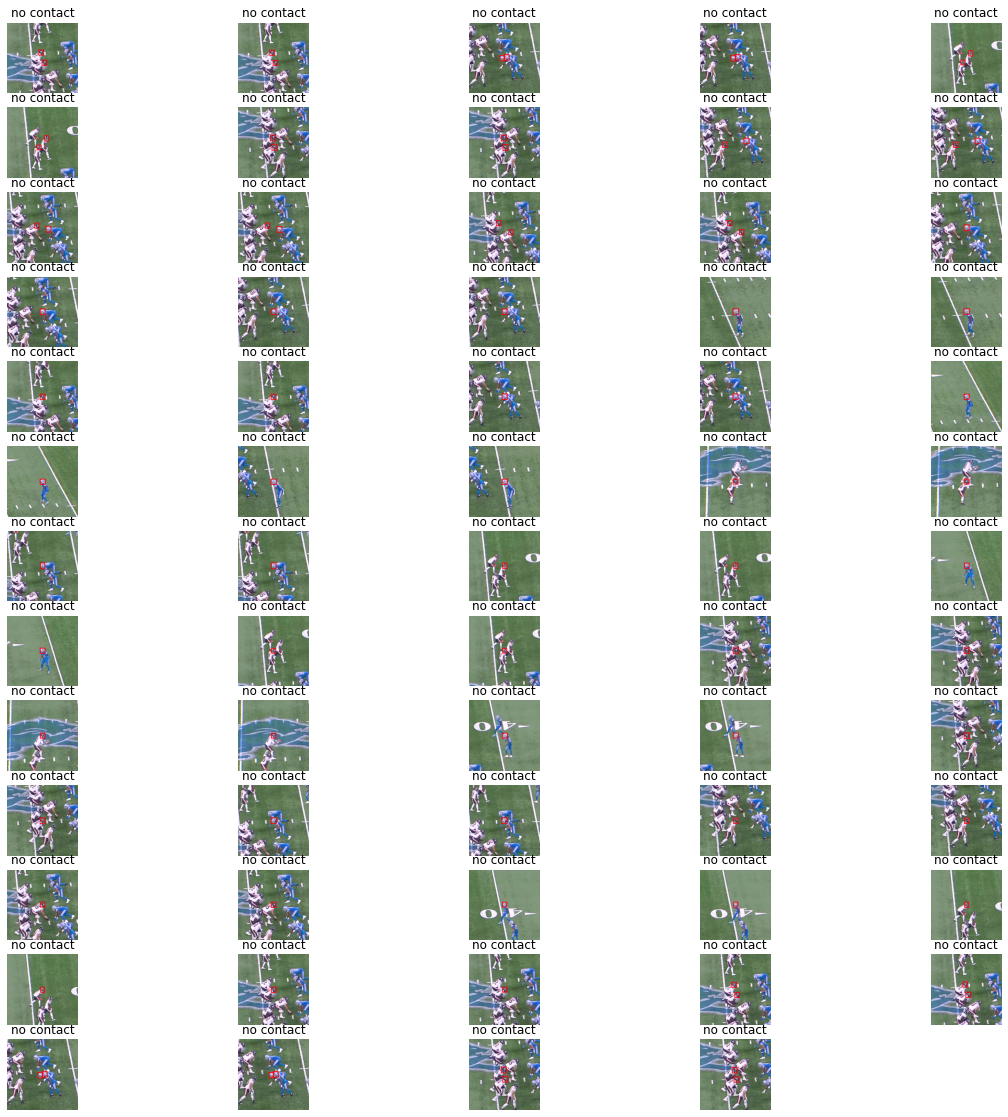

In [14]:
b = next(iter(test_loader))

visualize_batch(b, means, stds)

In [88]:
preds = torch.zeros((len(test_ds),))

with torch.no_grad():
    for i, b in enumerate(tqdm(test_loader)):
        
        if torch.cuda.is_available():
             b = b[0].to('cuda')
                
        b_preds = learn.model(b)
        
        # preds[i*bs: (i+1)*bs] = torch.softmax(b_preds, axis=1)[:, 1]
        
        break

  0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
from nflutils.validation import *

In [18]:
def get_matthews_corrcoef(val_dist_agg, pred_col='contact_pred_rolling', thresh=0.5):
    out = np.where(val_dist_agg['contact_pred'].isna(),
                   val_dist_agg['distance'] <= 1, 
                   val_dist_agg[pred_col] > thresh).astype(int)
    
    return matthews_corrcoef(val_dist_agg['contact'], out)

In [23]:
ss_dist_with_helmets.loc[:, 'contact_pred'] = preds
sub = smooth_predictions(ss_dist_with_helmets, 5, True)

sub = merge_combo_val(ss_dist, sub, pred_col='contact_pred_rolling')
get_matthews_corrcoef(sub, thresh=0.64)

  0%|          | 0/6387 [00:00<?, ?it/s]

0.622131250930468

In [39]:
# sub = merge_combo_val(ss_dist, ss_dist_with_helmets, pred_col='contact_pred')
get_matthews_corrcoef(sub, 'contact_pred', thresh=0.5)

0.5442237424483249

In [89]:
CrossEntropyLossFlat().activation(b_preds)[:, 1]

TensorBase([0.8243, 0.9998, 0.8619, 0.5144, 0.0265, 0.3219, 0.1865, 0.0143,
            0.8952, 0.6173, 0.9670, 0.5498, 0.4759, 0.4306, 0.7658, 0.5277,
            0.2801, 0.4688, 0.1494, 0.0135, 0.2278, 0.2613, 0.1136, 0.0869,
            0.0189, 0.2730, 0.4799, 0.1554, 0.5281, 0.7334, 1.0000, 0.4886,
            0.0051, 0.1719, 0.2445, 0.0079, 0.7587, 0.3798, 0.9220, 0.5039,
            0.2831, 0.2511, 0.4462, 0.6241, 0.2708, 0.1491, 0.1376, 0.0049,
            0.5442, 0.1110, 0.0669, 0.0628, 0.0263, 0.1514, 0.2537, 0.0285,
            0.8105, 0.7189, 0.9997, 0.6782, 0.0244, 0.1750, 0.2179, 0.0345],
           device='cuda:0')

In [81]:
rgb_bbox_1.contact_pred.head()

0    0.020216
1    0.712532
2    0.034326
3    0.011812
4    0.000615
Name: contact_pred, dtype: float64

In [50]:
sub.head()

,contact_id,game_play,step,nfl_player_id_1,nfl_player_id_2,contact,datetime,x_position_1,y_position_1,x_position_2,y_position_2,distance,contact_pred
0,58173_003606_0_46183_52475,58173_003606,0,46183,52475,0,2020-09-13 19:45:12.500000+00:00,67.58,23.63,67.74,20.93,2.704737,NaN
1,58173_003606_0_46183_47864,58173_003606,0,46183,47864,0,2020-09-13 19:45:12.500000+00:00,67.58,23.63,80.34,20.12,13.233960,NaN
2,58173_003606_0_46183_47929,58173_003606,0,46183,47929,0,2020-09-13 19:45:12.500000+00:00,67.58,23.63,74.00,34.04,12.230474,NaN
3,58173_003606_0_46183_47826,58173_003606,0,46183,47826,0,2020-09-13 19:45:12.500000+00:00,67.58,23.63,67.83,26.80,3.179843,NaN
4,58173_003606_0_46183_52581,58173_003606,0,46183,52581,0,2020-09-13 19:45:12.500000+00:00,67.58,23.63,65.84,37.45,13.929106,NaN


In [50]:
ss_dist_with_helmets.shape

(192981, 33)

In [19]:
ss_dist_with_helmets.loc[:, 'contact_pred'] = torch.sigmoid(preds)
sub = smooth_predictions(ss_dist_with_helmets, 5, True)

sub = merge_combo_val(ss_dist, sub, pred_col='contact_pred')
get_matthews_corrcoef(sub, pred_col='contact_pred', thresh=0.5)

0.44488878956935946

In [51]:
# sub = ss.merge(ss_dist_with_helmets[['contact_id', 'contact_pred', 'contact_pred_rolling', 'distance']], how='left', on='contact_id')
# sub['distance'] = sub.distance.fillna(99)

In [34]:
get_matthews_corrcoef(ss_dist, thresh=0.64)

0.708660530417308

In [104]:
test_ds = NFLFrameDataset(ss_dist_with_helmets, transform=val_transform, crop_size=256)

test_loader = DataLoader(
    test_ds, batch_size=bs, shuffle=False, num_workers=8, pin_memory=True,
)

data = DataLoaders(test_loader, test_loader)

# model, model_info = create_timm_model('convnext_tiny', n_out=2, n_in=3)
model = torch.load(CFG.utils_path+f'/{name}.pkl')

learn = Learner(data, model, CrossEntropyLossFlat(), metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                    # WandbCallback(log_preds=False, seed=seed),
                    # SaveModelCallback(monitor='matthews_corrcoef', fname=name)
                ]
               ).to_fp16()

# learn = learn.load(name)


learn.model = learn.model.cuda()

In [105]:
preds, _ = learn.get_preds(dl=test_loader)

In [106]:
ss_dist_with_helmets.loc[:, 'contact_pred'] = preds[:, 1].cpu().detach().numpy()

In [107]:
sub = smooth_predictions(ss_dist_with_helmets, 5, True)

  0%|          | 0/6387 [00:00<?, ?it/s]

In [ ]:
sub = merge_combo_val(ss_dist, sub, pred_col='contact_pred_rolling')

In [117]:
get_matthews_corrcoef(sub, pred_col='contact_pred_rolling', thresh=0.6)

0.7132943717571135

# Validation Pipeline

In [13]:
from nflutils.validation import *

In [25]:
rgb_bbox_1 = pd.read_csv('rgb-bbox-1.csv')
rgb_bbox_1['contact_pred'] = rgb_bbox_1['preds_1']

In [49]:
rgb_bbox_1.shape

(192981, 36)

In [17]:
rgb_bbox_1 = smooth_predictions(rgb_bbox_1, 5, True)

  0%|          | 0/6365 [00:00<?, ?it/s]

In [22]:
def get_matthews_corrcoef(val_dist_agg, pred_col='contact_pred_rolling', thresh=0.5):
    out = np.where(val_dist_agg['contact_pred'].isna(),
                   val_dist_agg['distance'] <= 1, 
                   val_dist_agg[pred_col] > thresh).astype(int)
    
    return matthews_corrcoef(val_dist_agg['contact'], out)

In [20]:
ss_dist = merge_combo_val(ss_dist, rgb_bbox_1, pred_col='contact_pred_rolling')

In [23]:
get_matthews_corrcoef(ss_dist, thresh=0.64)

0.708660530417308

In [58]:
torch.sigmoid(preds)

tensor([0.5550, 0.9987, 0.5975,  ..., 0.1771, 0.4838, 0.9085])

In [56]:
rgb_bbox_1

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,x_position_2,...,left,bottom,right,center_y,center_x,is_valid,path,preds_0,preds_1,contact_pred
0,58173_003606_0_41475_46108,58173_003606,2020-09-13 19:45:12.500000+00:00,0,41475,46108,0,65.26,27.27,65.51,...,309.0,389.0,338.0,361.0,323.0,True,frames/content/work/frames/train/58173_003606_Sideline.mp4_0296.jpg,0.979784,0.020216,0.020216
1,58173_003606_0_43330_52475,58173_003606,2020-09-13 19:45:12.500000+00:00,0,43330,52475,0,68.04,19.21,67.74,...,423.0,499.0,457.0,487.0,440.0,True,frames/content/work/frames/train/58173_003606_Sideline.mp4_0296.jpg,0.287468,0.712532,0.712532
2,58173_003606_0_41290_46120,58173_003606,2020-09-13 19:45:12.500000+00:00,0,41290,46120,0,66.33,34.50,65.71,...,301.0,236.0,344.0,210.0,322.0,True,frames/content/work/frames/train/58173_003606_Sideline.mp4_0296.jpg,0.965674,0.034326,0.034326
3,58173_003606_0_38642_43320,58173_003606,2020-09-13 19:45:12.500000+00:00,0,38642,43320,0,65.30,20.71,65.38,...,315.0,488.0,339.0,461.0,327.0,True,frames/content/work/frames/train/58173_003606_Sideline.mp4_0296.jpg,0.988188,0.011812,0.011812
4,58173_003606_0_35534_43330,58173_003606,2020-09-13 19:45:12.500000+00:00,0,35534,43330,0,66.17,18.75,68.04,...,360.0,509.0,457.0,492.0,408.0,True,frames/content/work/frames/train/58173_003606_Sideline.mp4_0296.jpg,0.999385,0.000615,0.000615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192976,58581_000040_51_47846_G,58581_000040,2021-10-11 00:22:50+00:00,51,47846,G,0,38.24,23.28,NaN,...,682.0,444.0,696.0,435.0,689.0,True,frames/content/work/frames/train/58581_000040_Endzone.mp4_0602.jpg,0.998306,0.001694,0.001694
192977,58581_000040_51_52596_G,58581_000040,2021-10-11 00:22:50+00:00,51,52596,G,0,59.31,32.87,NaN,...,1187.0,646.0,1196.0,639.0,1191.0,True,frames/content/work/frames/train/58581_000040_Endzone.mp4_0602.jpg,0.983182,0.016818,0.016818
192978,58581_000040_51_42511_G,58581_000040,2021-10-11 00:22:50+00:00,51,42511,G,0,19.72,21.77,NaN,...,652.0,322.0,666.0,314.0,659.0,True,frames/content/work/frames/train/58581_000040_Endzone.mp4_0602.jpg,0.997872,0.002128,0.002128
192979,58581_000040_51_53079_G,58581_000040,2021-10-11 00:22:50+00:00,51,53079,G,0,34.04,8.70,NaN,...,98.0,406.0,113.0,399.0,105.0,True,frames/content/work/frames/train/58581_000040_Endzone.mp4_0602.jpg,0.990366,0.009634,0.009634
